In [23]:
#Problem 1

%matplotlib inline

import kplr
client = kplr.API()
koi = client.koi(97.01) # Find the target KOI.
lcs = koi.get_light_curves(short_cadence=False) # Get list of datasets.
f = lcs[0].open() # open the first light-curve dataset
hdu_data = f[1].data
time = hdu_data["time"]  # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
flux_err = hdu_data["sap_flux_err"] # get the error in the flux
f.close()

#Extract the data in the time range

Time = []
Flux = []
Flux_err = []

for i in range(0,len(time)):
    if 124 < time[i] < 125:
        Time.append(time[i])
        Flux.append(flux[i])
        Flux_err.append(flux_err[i])

#Find average extracted flux values
#Exclude the transit
        
import math

def two_sigma_clipper(F):
    F_bar_prime = sum(F)/len(F)
    sigma_prime = (sum((F-F_bar_prime)**2)/len(F))**0.5
    sum_excluding_transit = 0
    n = 0
    for i in F:
        if math.fabs(i-F_bar_prime)/sigma_prime > 2:
            F.remove(i)
        else: 
            sum_excluding_transit += i
            n += 1
    F_bar = sum_excluding_transit/n
    sigma = (sum((F-F_bar)**2)/len(F))**0.5
    return F, F_bar, sigma

#Repeat this five times
    
F = Flux[:]      
for i in range(0,6):
    F, F_bar, sigma = two_sigma_clipper(F)
    i += 1

#Normalize stellar flux
    
normalized_flux = Flux/F_bar
normalized_flux_err = Flux_err/F_bar

#Use the ratio of obscured 
#to unobscured flux computed in problem set #2.

import scipy.integrate as integrate

def mu(r):
    return (1 - r**2)**(0.5)

def I(r):
    return 1 - (1 - mu(r)**(0.5))

#define the piecewise function d(p,r,z)
    
def d(p,r,z):
    if r >= z + p or r <= z - p:
        d = 0
    elif r + z <= p:
        d = 1
    else: 
        d = ((math.pi)**(-1))*math.acos((z**2 - p**2 + r**2)/(2*z*r))
    return d

def top(r,p,Z):
    return I(r)*(1-d(p,r,Z))*2*r

def bottom(r):
    return I(r)*2*r

def F(t_i,p,tau,t_0):
    Z = math.fabs((t_i-t_0)/tau)
    total_top = integrate.quad(top, 0, 1, args=(p,Z))
    total_bottom = integrate.quad(bottom, 0, 1)
    top_integral, error = (total_top)
    bottom_integral, error = (total_bottom)
    return top_integral/bottom_integral

p = 0.0775
tau = 0.1
t_0 = 124.51

chi_squared = 0
F_list = []
for i in range(0, len(Time)):
    chi_squared += \
    ((normalized_flux[i]-F(Time[i],p,tau,t_0))/normalized_flux_err[i])**2
    F_list.append(F(Time[i],p,tau,t_0))

By eye the fit looks pretty good
p = 0.999998293669
chi squared = 3.41266450878e-06
Since the p-value is close to one, this is a pretty good fit


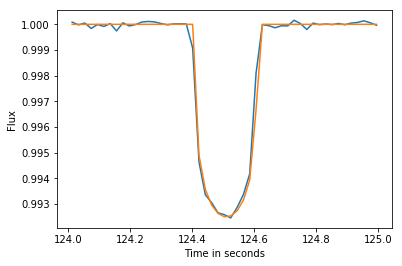

In [24]:
#Problem 2

%matplotlib inline

from pylab import *
from scipy import stats

plot(Time,normalized_flux)
plot(Time,F_list)
xlabel('Time in seconds')
ylabel('Flux')

print('By eye the fit looks pretty good')

#Compute how likely the value of chi_squared is
#Errors have normal distribution

M = 3
N = len(Time)
nu = N - M
chisq, P = stats.chisquare(F_list, normalized_flux, nu)
print('p = '+str(P))
print('chi squared = '+str(chisq))
print('Since the p-value is close to one, this is a pretty good fit')

p = 0.999999123527


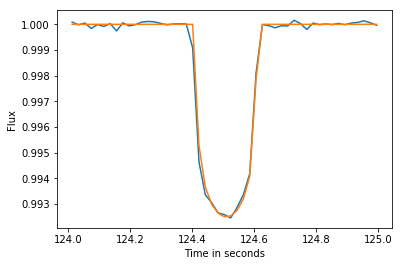

In [33]:
#Problem 3

%matplotlib inline

#Find the minimum in chi_squared and report this best fitting τ value

tol = 10**(-10)

def chi_squared(x):
    F_list = []
    for i in range(0, len(Time)):
        F_list.append(F(Time[i],p,x,t_0))
    chisq, P = stats.chisquare(F_list, normalized_flux)
    return chisq

def chi_squared_prime(tau):
    return (chi_squared(tau+tol) - chi_squared(tau-tol))/(2*tol)

a = 0.08
b = 0.13

while b - a > tol:
    m = (a + b)/2
    if sign(chi_squared_prime(a)) == sign(chi_squared_prime(m)):
        a = m
    else:
        b = m

m = (a + b)/2
A_list = []
for i in range(0, len(Time)):
    A_list.append(F(Time[i],p,m,t_0))
chisq, P = stats.chisquare(A_list, normalized_flux, nu)

#plot the result and determine the corresponding p-value.

plot(Time,normalized_flux)
plot(Time,A_list)
xlabel('Time in seconds')
ylabel('Flux')

print('p = '+str(P))